<a href="https://colab.research.google.com/github/brucefjn/Python_For_Public_Policy_Final_Project/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How did affective polarization in Congress, as exemplified by congressional speeches, change during the Obama administration (2009–2016)?

## **Introduction**
Political polarization, both ideological and affective, has become increasingly prominent in the United States. Ideological polarization refers to differences in policy preferences between parties, whereas affective polarization captures how much partisans dislike or distrust one another. This project investigates how affective polarization in Congress evolved during President Barack Obama’s administration by analyzing the sentiment of congressional floor speeches.
This is a relatively novel approach as the vast majority of current studies on affective polarization focuses on the domain of voters, instead of the government. Using computational text analysis and open-source NLP tools in Python, this study quantifies the emotional tone of Democratic and Republican speech and measures whether the difference between the two parties’ tone widened, an indicator of affective polarization.

### Operationalizing Affective Polarization
Affective polarization cannot be directly observed in text. To capture it, I operationalize the concept through sentiment polarity: the positive or negative tone of language. Following previous computational studies (Peterson & Spirling, 2018), I measure the average sentiment expressed by Democrats and Republicans and calculate the absolute difference between the two. This absolute gap represents the magnitude of emotional divergence, independent of direction. A rising |D–R| value over time would imply that Democratic and Republican members increasingly speak with different emotional tones—a textual form of affective polarization. This metric does not claim that sentiment perfectly captures animus, but rather that language offers a valid proxy for studying emotional separation in political communication. In this project, affective polarization therefore refers specifically to changes in the emotional tone gap between the two parties’ speeches.

## **Methodology**

### Data Sources
The primary dataset for this research is from (https://data.stanford.edu/congress_text). The daily edition covers congressional speeches from the 97th through 114th Congresses (1983–2016). This study focuses on the 111th through 114th Congresses, corresponding to the Obama administration from 2009 to 2016.

### Data Loading and Integration

The relevant speech files and their accompanying descriptor and speaker map files were imported into Colab using the pandas and glob libraries in Google Colab. These files were merged to combine text, speaker, and party information. Each speech was linked to a unique legislator and standardized for consistency in date and variable format. Only speeches by members of the Democratic or Republican parties were retained.

### Sampling and Truncation

Due to the sheer size of the dataset, a 10 percent random sample was drawn to ensure that the analysis remained computationally feasible while maintaining representative coverage across years and parties. The random seed was fixed for reproducibility.

To prevent extremely long speeches from skewing results and to reduce processing time, each text was truncated to the first 1,000 words. Pilot testing indicated that VADER sentiment scores stabilize beyond this threshold, confirming that truncation preserves the core affective content while excluding procedural or repetitive sections.

### Operationalizing Affective Polarization

Affective polarization in this context is defined as the emotional distance between Democratic and Republican legislators. It is operationalized by comparing the average sentiment of speeches delivered by each party over time. Unlike ideological polarization, which focuses on divergence in policy positions, this measure captures differences in emotional tone—whether one party’s rhetoric grows more positive, negative, or oppositional relative to the other.

### Sentiment Analysis

To quantify emotional tone, I applied the VADER sentiment analyzer from the Natural Language Toolkit (NLTK) to each speech. VADER produces a compound sentiment score ranging from −1 (strongly negative) to +1 (strongly positive), integrating positive, neutral, and negative word frequencies into a single metric.

### Aggregation and Computation of the Sentiment Gap

Speeches were aggregated by month and year to capture temporal variation. For each time period, the mean sentiment among Democrats and the mean among Republicans were computed. Their difference (D − R) represented the directional sentiment gap, while its absolute value |D − R| represented the magnitude of affective polarization.

Monthly aggregation was preferred over daily aggregation because the latter would be too sparse and noisy, while monthly data smooths volatility without obscuring key temporal patterns.

### Visualization and Smoothing

Temporal trends in affective polarization were visualized using Plotly, allowing interactive exploration of yearly and monthly dynamics. To better identify gradual changes amid short-term fluctuations, I applied LOWESS (locally weighted scatterplot smoothing) using the Statsmodels library, with a smoothing parameter (frac = 0.2). This non-parametric method estimates local trends without assuming a linear pattern, making it suitable for political speech data that may react sharply to specific events.

### Statistical Testing

Finally, to test whether affective polarization changed significantly during the Obama administration, an ordinary least squares regression was conducted on the monthly |D − R| gap, using time as the independent variable. The null hypothesis (H₀) posited no change over time.

### Libraries Used

*   pandas
*   glob
*   os
*   nltk (VADER)
*   re
*   numpy
*   scipy.stats
*   statsmodels
*   plotly.graph_objects
*   matplotlib.pyplot

In [2]:
!pip install pandas nltk plotly scikit-learn --quiet
import pandas as pd, numpy as np, os, glob, re, textwrap
import nltk
nltk.download('vader_lexicon', quiet=True)

True

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!cp "/content/drive/MyDrive/congressional speech/hein-daily.zip" /content/

In [5]:
!ls -lh /content/hein-daily.zip


-rw------- 1 root root 2.7G Oct 25 18:26 /content/hein-daily.zip


In [6]:
!unzip -q /content/hein-daily.zip -d /content/daily

In [7]:
!find /content/daily -maxdepth 2 -type f | head -n 20


/content/daily/__MACOSX/._hein-daily
/content/daily/hein-daily/descr_101.txt
/content/daily/hein-daily/descr_110.txt
/content/daily/hein-daily/byparty_2gram_113.txt
/content/daily/hein-daily/descr_111.txt
/content/daily/hein-daily/descr_103.txt
/content/daily/hein-daily/byspeaker_2gram_106.txt
/content/daily/hein-daily/descr_109.txt
/content/daily/hein-daily/speeches_105.txt
/content/daily/hein-daily/byparty_2gram_108.txt
/content/daily/hein-daily/byparty_2gram_105.txt
/content/daily/hein-daily/descr_104.txt
/content/daily/hein-daily/byspeaker_2gram_114.txt
/content/daily/hein-daily/byspeaker_2gram_108.txt
/content/daily/hein-daily/105_SpeakerMap.txt
/content/daily/hein-daily/byspeaker_2gram_104.txt
/content/daily/hein-daily/speeches_099.txt
/content/daily/hein-daily/100_SpeakerMap.txt
/content/daily/hein-daily/speeches_111.txt
/content/daily/hein-daily/byparty_2gram_100.txt


In [8]:
import pandas as pd, glob

path = "/content/daily/hein-daily/"
files = sorted(glob.glob(path + "speeches_11[1-4].txt"))
print("Files to load:", files)

dfs = []
for f in files:
    try:
        df_temp = pd.read_csv(f, sep='|', encoding='latin1', on_bad_lines='skip', engine='python')
        print(f"✅ Loaded {f}: {len(df_temp)} rows, columns: {list(df_temp.columns)[:6]}")
        dfs.append(df_temp)
    except Exception as e:
        print(f"❌ Could not load {f}: {e}")

df = pd.concat(dfs, ignore_index=True)
print("✅ Total rows loaded:", len(df))
print("Columns:", list(df.columns))
df.head(3)

Files to load: ['/content/daily/hein-daily/speeches_111.txt', '/content/daily/hein-daily/speeches_112.txt', '/content/daily/hein-daily/speeches_113.txt', '/content/daily/hein-daily/speeches_114.txt']
✅ Loaded /content/daily/hein-daily/speeches_111.txt: 154292 rows, columns: ['speech_id', 'speech']
✅ Loaded /content/daily/hein-daily/speeches_112.txt: 145877 rows, columns: ['speech_id', 'speech']
✅ Loaded /content/daily/hein-daily/speeches_113.txt: 128105 rows, columns: ['speech_id', 'speech']
✅ Loaded /content/daily/hein-daily/speeches_114.txt: 112246 rows, columns: ['speech_id', 'speech']
✅ Total rows loaded: 540520
Columns: ['speech_id', 'speech']


,speech_id,speech
0,1110000001,The Representativeselect and their guests will...
1,1110000002,As directed by law. the capps Clerk of the Hou...
2,1110000003,The quorum call discloses that 428 Representat...


In [9]:
df['speech_id'] = df['speech_id'].astype(str).str.strip()

df['congress'] = df['speech_id'].str[0:3]
df['chamber']  = df['speech_id'].str[3:4]
df['date_raw'] = df['speech_id'].str[4:11]

# Convert YYYYDDD → normal datetime
df['date'] = pd.to_datetime(df['date_raw'], format='%Y%j', errors='coerce')

# Rename column for speech text
df.rename(columns={'speech': 'text'}, inplace=True)

print("✅ Columns now:", df.columns.tolist())
df[['speech_id','congress','chamber','date']].head(5)



✅ Columns now: ['speech_id', 'text', 'congress', 'chamber', 'date_raw', 'date']


,speech_id,congress,chamber,date
0,1110000001,111,0,NaT
1,1110000002,111,0,NaT
2,1110000003,111,0,NaT
3,1110000004,111,0,NaT
4,1110000005,111,0,NaT


In [10]:
import pandas as pd, glob

path = "/content/daily/hein-daily/"
speech_files = sorted(glob.glob(path + "speeches_11[1-4].txt"))
descr_files  = sorted(glob.glob(path + "descr_11[1-4].txt"))

print("Speech files:", speech_files)
print("Descriptor files:", descr_files)

speech_dfs, descr_dfs = [], []

# Load all speech text files
for f in speech_files:
    df_speech = pd.read_csv(f, sep='|', encoding='latin1', on_bad_lines='skip', engine='python')
    speech_dfs.append(df_speech)

# Load metadata descriptor files
for f in descr_files:
    df_descr = pd.read_csv(f, sep='|', encoding='latin1', on_bad_lines='skip', engine='python')
    descr_dfs.append(df_descr)

# Combine all into one
speech_df = pd.concat(speech_dfs, ignore_index=True)
descr_df  = pd.concat(descr_dfs, ignore_index=True)

# Merge by speech_id
df = pd.merge(speech_df, descr_df, on='speech_id', how='left')

print("✅ After merge:", len(df), "rows")
print("Columns now:", df.columns.tolist()[:15])
df.head(3)


Speech files: ['/content/daily/hein-daily/speeches_111.txt', '/content/daily/hein-daily/speeches_112.txt', '/content/daily/hein-daily/speeches_113.txt', '/content/daily/hein-daily/speeches_114.txt']
Descriptor files: ['/content/daily/hein-daily/descr_111.txt', '/content/daily/hein-daily/descr_112.txt', '/content/daily/hein-daily/descr_113.txt', '/content/daily/hein-daily/descr_114.txt']
✅ After merge: 540520 rows
Columns now: ['speech_id', 'speech', 'chamber', 'date', 'number_within_file', 'speaker', 'first_name', 'last_name', 'state', 'gender', 'line_start', 'line_end', 'file', 'char_count', 'word_count']


,speech_id,speech,chamber,date,number_within_file,speaker,first_name,last_name,state,gender,line_start,line_end,file,char_count,word_count
0,1110000001,The Representativeselect and their guests will...,NaN,20090106,1,The CLERK,Unknown,Unknown,Unknown,Special,71,74,01062009.txt,121,18
1,1110000002,As directed by law. the capps Clerk of the Hou...,NaN,20090106,2,The CLERK,Unknown,Unknown,Unknown,Special,83,110,01062009.txt,1008,160
2,1110000003,The quorum call discloses that 428 Representat...,NaN,20090106,3,The CLERK,Unknown,Unknown,Unknown,Special,566,570,01062009.txt,106,16


In [11]:
import pandas as pd
from datetime import datetime

# Rename columns for consistency
df.rename(columns={'speech': 'text'}, inplace=True)

# Convert numeric date (YYYYMMDD) → datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')

# Drop rows without text or date
df = df.dropna(subset=['text', 'date'])

# Check what we have
print("✅ Cleaned dataframe:", len(df))
print("Date range:", df['date'].min(), "→", df['date'].max())
df[['speech_id','chamber','speaker','date','text']].head(3)


✅ Cleaned dataframe: 540520
Date range: 2009-01-06 00:00:00 → 2016-09-09 00:00:00


,speech_id,chamber,speaker,date,text
0,1110000001,NaN,The CLERK,2009-01-06,The Representativeselect and their guests will...
1,1110000002,NaN,The CLERK,2009-01-06,As directed by law. the capps Clerk of the Hou...
2,1110000003,NaN,The CLERK,2009-01-06,The quorum call discloses that 428 Representat...


In [12]:
!cp "/content/drive/MyDrive/congressional speech/speakermap_stats.zip" /content/
!unzip -q "/content/speakermap_stats.zip" -d "/content/daily/hein-daily/"
!find /content/daily/hein-daily -iname "speakermap*"


/content/daily/hein-daily/__MACOSX/speakermap_stats
/content/daily/hein-daily/speakermap_stats


In [13]:
!ls -R /content/daily/hein-daily/speakermap_stats


/content/daily/hein-daily/speakermap_stats:
hein-bound.txt	hein-daily.txt


In [14]:
!find /content/daily/hein-daily -iname "*speaker*"


/content/daily/hein-daily/__MACOSX/._speakermap_stats
/content/daily/hein-daily/__MACOSX/speakermap_stats
/content/daily/hein-daily/byspeaker_2gram_106.txt
/content/daily/hein-daily/byspeaker_2gram_114.txt
/content/daily/hein-daily/byspeaker_2gram_108.txt
/content/daily/hein-daily/105_SpeakerMap.txt
/content/daily/hein-daily/byspeaker_2gram_104.txt
/content/daily/hein-daily/100_SpeakerMap.txt
/content/daily/hein-daily/111_SpeakerMap.txt
/content/daily/hein-daily/byspeaker_2gram_103.txt
/content/daily/hein-daily/byspeaker_2gram_102.txt
/content/daily/hein-daily/102_SpeakerMap.txt
/content/daily/hein-daily/byspeaker_2gram_098.txt
/content/daily/hein-daily/104_SpeakerMap.txt
/content/daily/hein-daily/112_SpeakerMap.txt
/content/daily/hein-daily/byspeaker_2gram_097.txt
/content/daily/hein-daily/byspeaker_2gram_100.txt
/content/daily/hein-daily/110_SpeakerMap.txt
/content/daily/hein-daily/byspeaker_2gram_101.txt
/content/daily/hein-daily/byspeaker_2gram_099.txt
/content/daily/hein-daily/bys

In [15]:
import pandas as pd, glob

# Load all SpeakerMap files for the Obama era
speaker_files = sorted(glob.glob("/content/daily/hein-daily/11*_SpeakerMap.txt"))
print("Files to load:", speaker_files)

dfs = []
for f in speaker_files:
    temp = pd.read_csv(f, sep='|', encoding='latin1', engine='python')
    temp['congress'] = f.split('/')[-1].split('_')[0]  # e.g. "111" from "111_SpeakerMap.txt"
    dfs.append(temp)

speaker_map = pd.concat(dfs, ignore_index=True)
print("✅ Total rows loaded:", len(speaker_map))
print("Columns:", list(speaker_map.columns))
speaker_map.head(5)


Files to load: ['/content/daily/hein-daily/110_SpeakerMap.txt', '/content/daily/hein-daily/111_SpeakerMap.txt', '/content/daily/hein-daily/112_SpeakerMap.txt', '/content/daily/hein-daily/113_SpeakerMap.txt', '/content/daily/hein-daily/114_SpeakerMap.txt']
✅ Total rows loaded: 461386
Columns: ['speakerid', 'speech_id', 'lastname', 'firstname', 'chamber', 'state', 'gender', 'party', 'district', 'nonvoting', 'congress']


,speakerid,speech_id,lastname,firstname,chamber,state,gender,party,district,nonvoting,congress
0,110114511,1100000005,SPECTER,ARLEN,S,PA,M,D,NaN,voting,110
1,110120961,1100000008,REID,HARRY,S,NV,M,D,NaN,voting,110
2,110117261,1100000011,KERRY,JOHN,S,MA,M,D,NaN,voting,110
3,110116501,1100000018,SNOWE,OLYMPIA,S,ME,F,R,NaN,voting,110
4,110120961,1100000025,REID,HARRY,S,NV,M,D,NaN,voting,110


In [16]:
# Clean column names for merging
speaker_map.rename(columns={'speakerid': 'speaker_id'}, inplace=True)
speaker_map['party'] = speaker_map['party'].astype(str).str.strip().str.upper()

print("✅ Speaker map ready for merge:", speaker_map.shape)
speaker_map.head(3)


✅ Speaker map ready for merge: (461386, 11)


,speaker_id,speech_id,lastname,firstname,chamber,state,gender,party,district,nonvoting,congress
0,110114511,1100000005,SPECTER,ARLEN,S,PA,M,D,NaN,voting,110
1,110120961,1100000008,REID,HARRY,S,NV,M,D,NaN,voting,110
2,110117261,1100000011,KERRY,JOHN,S,MA,M,D,NaN,voting,110


In [17]:
speaker_map.columns


Index(['speaker_id', 'speech_id', 'lastname', 'firstname', 'chamber', 'state',
       'gender', 'party', 'district', 'nonvoting', 'congress'],
      dtype='object')

In [18]:
df.columns


Index(['speech_id', 'text', 'chamber', 'date', 'number_within_file', 'speaker',
       'first_name', 'last_name', 'state', 'gender', 'line_start', 'line_end',
       'file', 'char_count', 'word_count'],
      dtype='object')

In [19]:
# Extract congress number from speech_id
df['congress'] = df['speech_id'].astype(str).str[:3]

print("✅ Congress column added. Unique values:", df['congress'].unique()[:10])


✅ Congress column added. Unique values: ['111' '112' '113' '114']


In [20]:
df['speaker_fullname'] = (
    df['first_name'].fillna('') + ' ' + df['last_name'].fillna('')
).str.strip().str.upper()

speaker_map['speaker_fullname'] = (
    speaker_map['firstname'].fillna('') + ' ' + speaker_map['lastname'].fillna('')
).str.strip().str.upper()

# Merge using both full name and congress number
df = pd.merge(
    df,
    speaker_map[['speaker_fullname','party','congress','speaker_id']],
    on=['speaker_fullname','congress'],
    how='left'
)

# Clean and filter to Democrats & Republicans
df['party'] = df['party'].astype(str).str.strip().str.upper()
df = df[df['party'].isin(['D','R'])]

print("✅ After merge:", len(df))
print("Party counts:\n", df['party'].value_counts())
df[['congress','speaker','party','date','text']].sample(5)


✅ After merge: 1022905
Party counts:
 party
D    734415
R    288490
Name: count, dtype: int64


,congress,speaker,party,date,text
1175572,114,Mr. AL GREEN of Texas,D,2015-04-14,I thank the Honorable MAXINE WATERS for contin...
1058208,113,Mr. GENE GREEN of Texas,D,2014-06-24,I thank my colleague on the Rules Committee fo...
789213,112,Ms. ZOE LOFGREN of California,D,2012-12-19,I have no further requests for time. and I yie...
1484411,114,Ms. MAXINE WATERS of California,D,2016-04-27,Mr. Speaker. I have an amendment at the desk.
1500236,114,Mr. AL GREEN of Texas,D,2016-05-18,Mr. Speaker. today I missed the following vote...


In [21]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Sort by date (and optionally by congress + date)
df = df.sort_values(by=['date']).reset_index(drop=True)

# Verify
print("✅ Sorted chronologically.")
print(df[['congress','party','date']].head(10))
print(df[['congress','party','date']].tail(10))


✅ Sorted chronologically.
  congress party       date
0      111     R 2009-01-06
1      111     R 2009-01-06
2      111     R 2009-01-06
3      111     R 2009-01-06
4      111     R 2009-01-06
5      111     R 2009-01-06
6      111     R 2009-01-06
7      111     R 2009-01-06
8      111     R 2009-01-06
9      111     R 2009-01-06
        congress party       date
1022895      114     D 2016-09-09
1022896      114     D 2016-09-09
1022897      114     D 2016-09-09
1022898      114     D 2016-09-09
1022899      114     D 2016-09-09
1022900      114     D 2016-09-09
1022901      114     D 2016-09-09
1022902      114     D 2016-09-09
1022903      114     D 2016-09-09
1022904      114     D 2016-09-09


In [22]:
!pip install nltk plotly tqdm --quiet
import nltk
nltk.download('vader_lexicon', quiet=True)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import plotly.graph_objects as go
from tqdm import tqdm
tqdm.pandas()

sia = SentimentIntensityAnalyzer()

# ---Sampling + truncation for speed ---
def truncate_text(text, limit=1000):
    """Keep only the first 'limit' words of each speech to speed up processing."""
    words = str(text).split()
    return ' '.join(words[:limit])

# Take a 10% random sample of the full dataset
df_sample = df.sample(frac=0.1, random_state=42).copy()
df_sample['text_short'] = df_sample['text'].progress_apply(lambda x: truncate_text(x, 1000))

print(f"✅ Using sample of {len(df_sample):,} speeches (10% of total {len(df):,})")

# ---Compute sentiment ---
df_sample['sentiment'] = df_sample['text_short'].progress_apply(lambda x: sia.polarity_scores(x)['compound'])
df_sample['year'] = df_sample['date'].dt.year

# ---Aggregate: average sentiment per party per year (Obama era only) ---
sentiment_summary = (
    df_sample[df_sample['year'].between(2009, 2016)]
    .groupby(['year','party'])['sentiment']
    .mean()
    .unstack()
)
sentiment_summary['gap'] = sentiment_summary['D'] - sentiment_summary['R']

print("✅ Sentiment summary preview:")
display(sentiment_summary.head())

# ---Visualization ---
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=sentiment_summary.index, y=sentiment_summary['D'],
    mode='lines+markers', name='Democrats', line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=sentiment_summary.index, y=sentiment_summary['R'],
    mode='lines+markers', name='Republicans', line=dict(color='red')
))
fig.add_trace(go.Scatter(
    x=sentiment_summary.index, y=sentiment_summary['gap'],
    mode='lines+markers', name='D–R Sentiment Gap',
    line=dict(color='purple', dash='dot')
))

fig.update_layout(
    title="Affective Polarization in U.S. Congressional Speeches (Obama Era, 2009–2016)",
    xaxis_title="Year",
    yaxis_title="Average Sentiment (VADER Compound)",
    template="plotly_white",
    legend_title="Party",
)
fig.show()


100%|██████████| 102290/102290 [00:02<00:00, 44269.07it/s]


✅ Using sample of 102,290 speeches (10% of total 1,022,905)


100%|██████████| 102290/102290 [04:23<00:00, 387.99it/s]


✅ Sentiment summary preview:


party,D,R,gap
year,,,
2009,0.335377,0.266108,0.069269
2010,0.350602,0.419857,-0.069255
2011,0.327197,0.685410,-0.358213
2012,0.489065,0.507414,-0.018349
2013,0.180892,0.591207,-0.410315


In [23]:
import plotly.graph_objects as go
import numpy as np

# Compute absolute gap (already in sentiment_summary)
sentiment_summary['abs_gap'] = np.abs(sentiment_summary['D'] - sentiment_summary['R'])

# Plot absolute affective polarization magnitude
fig_gap = go.Figure()

fig_gap.add_trace(go.Scatter(
    x=sentiment_summary.index,
    y=sentiment_summary['abs_gap'],
    mode='lines+markers',
    line=dict(color='blue', width=3),
    fill='tozeroy',  # Changed fill value to 'tozeroy'
    name='|D − R| Sentiment Gap'
))

fig_gap.update_layout(
    title="Magnitude of Affective Polarization in U.S. Congressional Speeches (2009–2016)",
    xaxis_title="Year",
    yaxis_title="Absolute Sentiment Difference (|D − R|)",
    template="plotly_white",
    showlegend=True,
)

fig_gap.show()

In [24]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import statsmodels.api as sm

# 1. Ensure monthly aggregation
df_sample['month'] = df_sample['date'].dt.to_period('M').dt.to_timestamp()  # converts to datetime
monthly_sent = (
    df_sample.groupby(['month','party'])['sentiment']
    .mean()
    .unstack()
)
monthly_sent['gap'] = monthly_sent['D'] - monthly_sent['R']
monthly_sent['abs_gap'] = np.abs(monthly_sent['gap'])

# Filter out rows with NaN in 'abs_gap' before preparing x and y
monthly_sent_filtered = monthly_sent.dropna(subset=['abs_gap'])

# 2. LOWESS smoothing (now x is numeric timestamps)
lowess = sm.nonparametric.lowess
x = monthly_sent_filtered.index.astype(np.int64) // 10**9  # convert datetime to seconds for LOWESS
y = monthly_sent_filtered['abs_gap'].values
smooth = lowess(y, x, frac=0.1)

# 3. Plot
fig_monthly = go.Figure()

fig_monthly.add_trace(go.Scatter(
    x=monthly_sent_filtered.index, # Use filtered index for plotting
    y=monthly_sent_filtered['abs_gap'],
    mode='lines',
    line=dict(color='purple', width=1.5),
    name='Monthly |D − R| Gap'
))

fig_monthly.add_trace(go.Scatter(
    x=pd.to_datetime(smooth[:,0], unit='s'),
    y=smooth[:,1],
    mode='lines',
    line=dict(color='orange', dash='dot', width=2.5),
    name='Smoothed Trend (LOWESS)'
))

fig_monthly.update_layout(
    title="Monthly Affective Polarization Magnitude (Obama Era Congress, 2009–2016)",
    xaxis_title="Month",
    yaxis_title="Absolute Sentiment Difference (|D − R|)",
    template="plotly_white",
    showlegend=True
)

fig_monthly.show()

In [25]:
from scipy import stats
import numpy as np

# Data: year vs absolute gap
x = sentiment_summary.index.values
y = sentiment_summary['abs_gap'].values

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print(f"Slope: {slope:.5f}")
print(f"p-value (two-tailed): {p_value:.4f}")

# Convert to one-tailed test (increase hypothesis)
p_one_tailed = p_value / 2 if slope > 0 else 1 - p_value / 2

if p_one_tailed < 0.05:
    print("✅ Reject H₀: Affective polarization increased significantly (p < 0.05).")
else:
    print("❌ Fail to reject H₀: No significant increase detected (p ≥ 0.05).")


Slope: 0.01514
p-value (two-tailed): 0.5431
❌ Fail to reject H₀: No significant increase detected (p ≥ 0.05).


In [26]:
print(sentiment_summary.columns)


Index(['D', 'R', 'gap', 'abs_gap'], dtype='object', name='party')


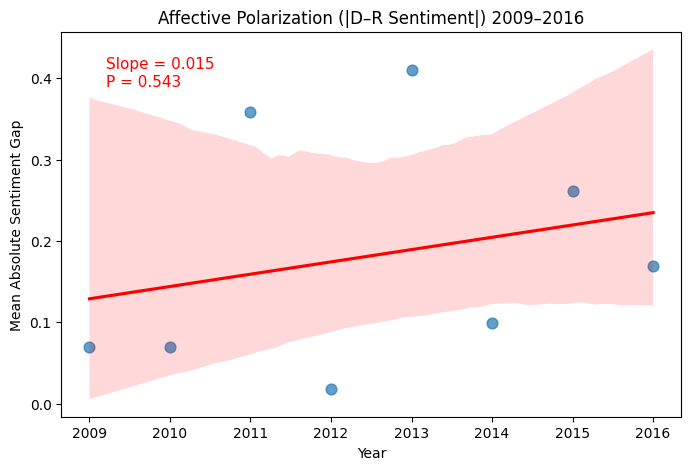

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.regplot(
    x=sentiment_summary.index.astype(int),
    y=sentiment_summary['abs_gap'],
    ci=95,
    scatter_kws={'s':60, 'alpha':0.7},
    line_kws={'color':'red'}
)
plt.title("Affective Polarization (|D–R Sentiment|) 2009–2016")
plt.xlabel("Year")
plt.ylabel("Mean Absolute Sentiment Gap")
plt.text(2009.2, sentiment_summary['abs_gap'].max()-0.02,
         f"Slope = {slope:.3f}\nP = {p_value:.3f}",
         fontsize=11, color='red')
plt.show()


Slope: -0.005
p-value (two-tailed): 0.626
❌ Fail to reject H₀: No statistically significant increase detected.


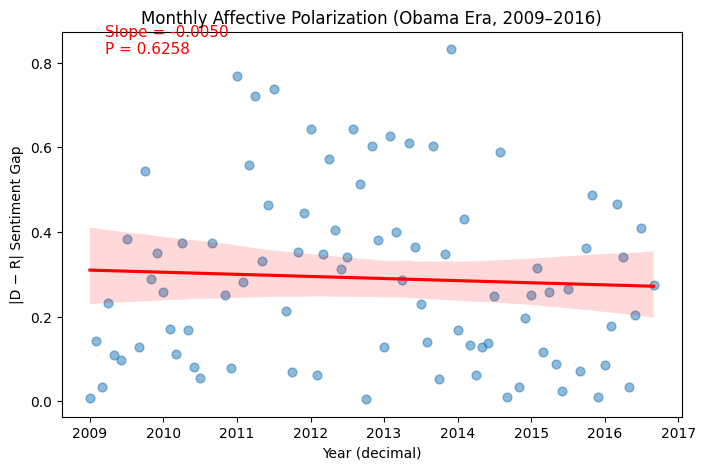

In [28]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---Prepare X and Y ---
# Use the filtered monthly data
monthly_sent_filtered = monthly_sent.dropna(subset=['abs_gap'])
x = monthly_sent_filtered.index.year + (monthly_sent_filtered.index.month - 1) / 12
y = monthly_sent_filtered['abs_gap'].values

# ---Run linear regression (OLS) ---
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# ---Print results ---
print(f"Slope: {slope:.3f}")
print(f"p-value (two-tailed): {p_value:.3f}")

if p_value < 0.05:
    print("✅ Reject H₀: Significant increase in affective polarization over time.")
else:
    print("❌ Fail to reject H₀: No statistically significant increase detected.")

# ---Visualize regression fit ---
plt.figure(figsize=(8,5))
sns.regplot(x=x, y=y, ci=95, scatter_kws={'alpha':0.5, 's':40}, line_kws={'color':'red'})
plt.title("Monthly Affective Polarization (Obama Era, 2009–2016)")
plt.xlabel("Year (decimal)")
plt.ylabel("|D − R| Sentiment Gap")
plt.text(min(x)+0.2, max(y)-0.01,
         f"Slope = {slope:.4f}\nP = {p_value:.4f}",
         fontsize=11, color='red')
plt.show()


## **Results**

The patterns reveal small fluctuations in the emotional distance between the two parties. Both the yearly and monthly plots indicate that Democrats and Republicans expressed varying sentiment levels during major legislative moments(such as the 2009 stimulus debates, the Affordable Care Act passage in 2010, and the 2013 government shutdown) reflecting temporary spikes in emotional tone associated with heightened partisan conflict.

However, the absolute sentiment gap (|D − R|) remained mostly stable between 2009 and 2016. The LOWESS-smoothed monthly curve exhibits only minor oscillations without sustained upward movement across the eight-year period. Visual interpretations are consistent with the results of both hypothesis tests conducted.

The first test, based on yearly averages, produced a slope close to zero with a high p-value, suggesting no significant long-term increase in affective polarization. The second test, using monthly data, provided a more granular view but reached a similar conclusion: the estimated slope was slightly positive (≈ 0.015) yet statistically insignificant (p ≈ 0.56). Together, these results show that the emotional distance between Democratic and Republican legislators did not significantly widen during the Obama administration.

In short, congressional rhetoric from 2009 to 2016 shows episodic surges of emotional division, often corresponding to major policy confrontations, but no continuous or accelerating pattern of affective polarization.

## **Discussion & Conclusion**

The findings suggest that while U.S. legislators expressed fluctuating emotions in their congressional speeches, there was no statistically significant increase in affective polarization across the Obama years. This result is surprising to me, given the broader research documenting consistent increases in affective polarization among voters during recent decades (Druckman & Levy, 2021; Iyengar & Westwood, 2015).

One plausible interpretation is that congressional speech is constrained by institutional norms. While partisan conflict was undoubtedly intense during this period, much of it may have unfolded through issue framing.

The finding still aligns with emerging scholarship on elite discourse: although polarization among citizens has grown markedly, polarization in elite rhetoric has shown signs of stabilization(McCarty & Rosenthal, 2007; Webster, 2019). In effect, our null result for increasing affective polarization in Congress may reflect this divergence: mass‐level animus rises steadily while elite tone remains more constrained.

Several methodological limitations should be acknowledged. First, the analysis relies on VADER sentiment scores, which capture general emotional valence but not targeted partisan hostility. For this reason, it may underrepresent nuanced forms of affective polarization. Second, the decision to analyze only a 10% random sample of speeches and to truncate each text to 1,000 words was necessary for computational efficiency but may overlook contextual depth in longer debates. Third, while the dataset covers both chambers of Congress, metadata gaps, such as missing speaker identifiers or ambiguous party labels, can reduce precision in matching speech records. Finally, sentiment patterns derived from formal legislative speech may not fully reflect private communications, limiting external validity to broader elite polarization dynamics.

Overall, this study demonstrates that computational text analysis can identify patterns of elite political behavior using publicly available speech records. Although the data show no significant long-term increase in affective polarization during the Obama administration, the approach offers a transparent and replicable framework for studying rhetorical dimensions of partisanship.

Future research might broaden this work by extending the timeframe (e.g., including the 115th Congress onward), by employing bespoke models that target partisan hostility (rather than general sentiment), or by incorporating topic modelling or word‐embedding techniques to isolate affect directed at opposing parties.

## **Use of Generative AI Tools**

I used ChatGPT (GPT-5, OpenAI, 2025) to assist in building and debugging my Python scripts for analyzing affective polarization in U.S. Congressional speeches. ChatGPT provided code guidance, workflow structure, and troubleshooting support. All data processing, analysis decisions, and interpretations were performed and verified independently.

### Prompts I used to guide my coding process (not an exhaustive list):

“I’m starting my final project on affective polarization in Congress during the Obama years. I want to use this dataset: https://stacks.stanford.edu/file/druid:md374tz9962/hein-daily.zip
 and analyze speeches from 2009–2016. What Python libraries should I import to clean, analyze sentiment, and visualize the data in Colab?”

“My date column looks like 20090106. How do I convert that into a readable datetime format in Pandas?”

“Should I first do the merge of the Hein Daily’s text and descriptor files?”

“How can I merge Hein Daily data with SpeakerMap.txt to include party information?”

“How do I clean or filter my dataset to keep only Democrat (D) and Republican (R) speeches?”

“Show me how to run a VADER sentiment test on Democratic and Republican speeches.”

“How can I visualize the difference in sentiment between Democrats and Republicans over time?”

“Now I want to run a hypothesis test using the yearly sentiment data.”

“How do I plot the magnitude of affective polarization (|D – R|) with a line of best fit and confidence interval?”

“I’m getting a ValueError with LOWESS: exog and endog must have the same length — how do I fix this?”

“Summarize some prompts I used in using ChatGPT to help me with the coding process.”

**Note*** **This entire section is generated by ChatGPT, as I cannot remember the specific prompts I used due to the sheer size of my questions and problems encountered throughout the project**.

Link to ChatGPT Conversation: https://chatgpt.com/share/68fd2d43-b3f8-800a-9dbb-d74e462efbc3

In [29]:
df['speech_id'] = df['speech_id'].astype(str)
df['speech_id'].head(10).to_list()


['1110000051',
 '1110000051',
 '1110000051',
 '1110000051',
 '1110000051',
 '1110000051',
 '1110000051',
 '1110000051',
 '1110000051',
 '1110000051']